<a href="https://colab.research.google.com/github/NivedithaGunapati/Personalized-Stress_Assessment/blob/main/PeacePulse_Stress_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
pip install pandas numpy nltk scikit-learn matplotlib wordcloud plotly dash transformers torch

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
from transformers import pipeline


In [35]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
# Initialize stemmer and stopwords
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [37]:

# Load dataset
data = pd.read_csv("Stress.csv")
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [39]:


# Preprocessing function
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

In [40]:

# Apply preprocessing to the text data
data['cleaned_text'] = data['text'].apply(clean_text)

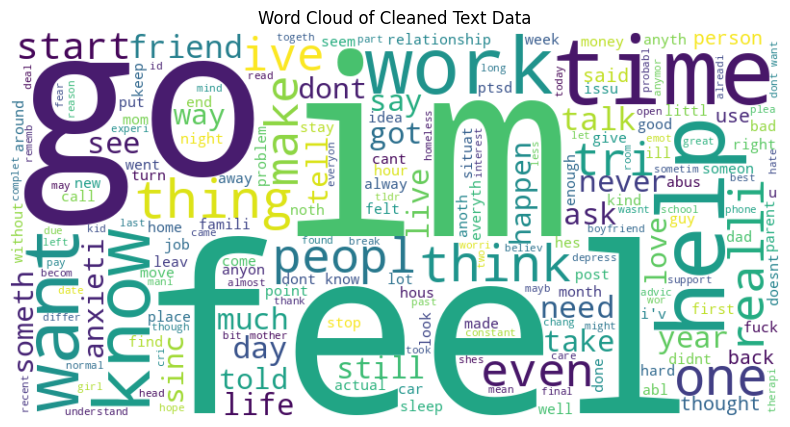

In [41]:
# Generate word cloud
all_text = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text Data')
plt.show()

In [42]:
# Feature extraction
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(data['cleaned_text'])

In [43]:
# Labels
y = data['label']

In [44]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:

# Define individual models
model1 = LogisticRegression()
model2 = BernoulliNB()
model3 = SVC(probability=True)

In [46]:


# Create an ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('lr', model1),
    ('nb', model2),
    ('svc', model3)
], voting='soft')

In [47]:

# Train ensemble model
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('nb', BernoulliNB()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [48]:

# Make predictions
y_pred = ensemble_model.predict(X_test)

In [49]:

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))


Accuracy: 0.7588028169014085
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       263
           1       0.76      0.80      0.78       305

    accuracy                           0.76       568
   macro avg       0.76      0.76      0.76       568
weighted avg       0.76      0.76      0.76       568



In [50]:
# Emotion Detection with BERT
emotion_detector = pipeline('sentiment-analysis', model='bhadresh-savani/distilbert-base-uncased-emotion')

# Function to detect emotions
def detect_emotions(text):
    emotions = emotion_detector(text)
    return emotions

In [51]:

# Function for personalized stress assessment
def assess_stress(user_input):
    user_input_cleaned = clean_text(user_input)
    user_input_vectorized = vectorizer.transform([user_input_cleaned])
    stress_level_prob = ensemble_model.predict_proba(user_input_vectorized)[0]
    return stress_level_prob

In [52]:
# Reason extraction based on keywords
def extract_reason(text):
    reasons = {
        'work': ['work', 'job', 'office', 'meeting', 'project', 'deadline'],
        'exams': ['exam', 'test', 'quiz', 'study', 'homework'],
        'relationships': ['relationship', 'partner', 'friend', 'family', 'love'],
        'health': ['health', 'doctor', 'illness', 'sick', 'hospital', 'medicine'],
        'finances': ['finance', 'money', 'budget', 'expense', 'bill', 'debt', 'loan'],
        'general': []
    }
    text = text.lower()
    for reason, keywords in reasons.items():
        if any(keyword in text for keyword in keywords):
            return reason
    return 'general'

In [53]:
def provide_recommendations(stress_confidence, reason):
    recommendations = {
        'work': {
            'stress': [
                "Take a 15-minute break and restart",
                html.Div(["Listen to some music. Have a look at one of my favorite playlists -> ",
                          html.A("click here", href="https://open.spotify.com/playlist/37i9dQZF1DXb5Hc9BmAT8t", target="_blank")]),
                "Have a cup of coffee/tea which might relax you",
                html.Div(["Listen to some jokes. ",
                          html.A("Click Here & Enjoy", href="https://www.funology.com/funology-jokes-and-riddles/", target="_blank")])
            ],
            'non_stress': [
                "Happy for you! Keep rocking..",
                "Continue with the same speed and be active",
                "Reward yourself for the work done by you"
            ]
        },
        'exams': {
            'stress': [
                "Review your study schedule. Do you want me to help in creating the schedule?",
                html.Div(["Create manually -> ",
                          html.A("click here", href="https://www.designcap.com/app/?category=schedule", target="_blank")]),
                html.Div(["Using AI -> ",
                          html.A("click here", href="https://www.taskade.com/generate/ai/study-schedule", target="_blank")]),
                "Take a short nap and then restart",
                "Watch some shows for entertainment. Have a look at some entertaining shows",
                 html.Div(["English -> ",
                          html.A("click here", href="https://youtube.com/playlist?list=PL4tNBHY4el9xYWqAHGk2PoYS7me4K78g6&si=oYRPllazMCtvXBBl", target="_blank")]),
                html.Div(["Hindi -> ",
                          html.A("click here", href="https://youtube.com/playlist?list=PLzufeTFnhupzZcxibjedZWfmNMqu-ozkg&si=ZqFuuxpnagP423rQ", target="_blank")]),
                html.Div(["Telugu -> ",
                          html.A("click here", href="https://youtube.com/playlist?list=PLzufeTFnhupzZcxibjedZWfmNMqu-ozkg&si=ZqFuuxpnagP423rQ", target="_blank")]),

            ],
            'non_stress': [
                "Good work! Let's celebrate the moment",
                "Stay on top of your study plan",
                "Keep continuing"
            ]
        },
        'relationships': {
            'stress': [
                "Communicate with your partner clearly",
                "Note down your feelings in a journal. Have a look at the journal to write",
                html.A("Click here", href="https://penzu.com/", target="_blank"),
                "Read a book or watch a movie. Here are the list of movies or books which may make you feel better",
                 html.Div(["Movies -> ",
                          html.A("click here", href="https://youtube.com/playlist?list=PLzufeTFnhupzZcxibjedZWfmNMqu-ozkg&si=ZqFuuxpnagP423rQ", target="_blank")]),
                 html.Div(["Books -> ",
                          html.A("click here", href="https://youtube.com/playlist?list=PLzufeTFnhupzZcxibjedZWfmNMqu-ozkg&si=ZqFuuxpnagP423rQ", target="_blank")]),
                "Go outside and chill with friends"
            ],
            'non_stress': [
                "Spend more time with your loved ones",
                "Plan a fun activity together",
                "Express feelings"
            ]
        },
        'health': {
            'stress': [
                "Consult a healthcare professional",
                "Practice stress-relief exercises like yoga",
                "Ensure adequate sleep and rest",
                "Follow a balanced diet"
            ],
            'non_stress': [
                "Maintain your healthy lifestyle",
                "Schedule regular check-ups",
                "Stay active with regular exercise",
                "Encourage others to adopt healthy habits"
            ]
        },
        'finances': {
            'stress': [
                "Create a budget plan",
                "Seek financial advice or counseling",
                "Prioritize expenses",
                "Take small steps to save money"
            ],
            'non_stress': [
                "Continue monitoring your expenses",
                "Set financial goals",
                "Reward yourself with a small purchase within your budget",
                "Review and adjust your savings plan"
            ]
        },
        'general': {
            'stress': [
                "Stay calm!",
                "Do you want to crack me any jokes..?",
                "Do watch movies,shows etc..",
                "Go for a walk in nature",
                "Listen to some melody songs..Have a look on some playlist which i like..",
                "Explore and try some new crafts or hobbies.."
            ],
            'non_stress': [
                " Stay positive!",
                "Keep engaging in the activities you like..Try to share with us about any activity u like ",
                "Stay connected with your family and friends"
            ]
        }
    }
    category = 'stress' if stress_confidence[1] >= 0.5 else 'non_stress'
    return recommendations[reason][category], stress_confidence[1 if category == 'stress' else 0]


In [54]:
# Continuous Learning Function
def continuous_learning(new_data, new_labels):
    global ensemble_model
    # Preprocess and vectorize new data
    new_data_cleaned = [clean_text(text) for text in new_data]
    new_data_vectorized = vectorizer.transform(new_data_cleaned)
    # Retrain the model
    ensemble_model.fit(new_data_vectorized, new_labels)

In [55]:

# Visualization of Insights
# Stress label distribution
stress_counts = data['label'].value_counts().reset_index()
stress_counts.columns = ['label', 'count']

fig1 = px.bar(stress_counts, x='label', y='count', title='Distribution of Stress Labels',
              labels={'label': 'Stress Label', 'count': 'Number of Posts'})

In [56]:
# Interactive graph for stressful posts by subreddit
subreddit_stress = data[data['label'] == 1]['subreddit'].value_counts().reset_index()
subreddit_stress.columns = ['subreddit', 'num_stress_posts']

fig2 = px.bar(subreddit_stress, x='subreddit', y='num_stress_posts',
              title='Stressful Posts by Subreddit', labels={'num_stress_posts': 'Number of Stressful Posts'},
              hover_data={'subreddit': True, 'num_stress_posts': True}, color_discrete_sequence=['#337482'])

fig2.update_layout(xaxis_title='Subreddit', yaxis_title='Number of Stressful Posts')


In [57]:
# Plotly Dash Dashboard
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("User Mood Dashboard"),
    dcc.Graph(id='mood-trends', figure=fig1),
    html.Div([
        dcc.Input(id='user-input', type='text', placeholder='Enter your current mood...', style={'width': '50%'}),
        html.Button('Submit', id='submit-button', n_clicks=0),
    ]),
    html.Div(id='recommendations-output')
])

@app.callback(
    Output('recommendations-output', 'children'),
    [Input('submit-button', 'n_clicks')],
    [State('user-input', 'value')]
)
def update_recommendations(n_clicks, value):
    if n_clicks > 0 and value:
        stress_confidence = assess_stress(value)
        reason = extract_reason(value)
        recommendations, confidence = provide_recommendations(stress_confidence, reason)
        return html.Div([
            html.H3(f"Stress Level: {'Stress' if stress_confidence[1] >= 0.5 else 'No-Stress'}"),
            html.P(f"Confidence: {confidence:.2f}"),
            html.H4(f"Reason: {reason.capitalize()}"),
            html.H4("Recommendations for you:"),
            html.Ul([html.Li(rec) for rec in recommendations])
        ])

if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>